# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [0]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

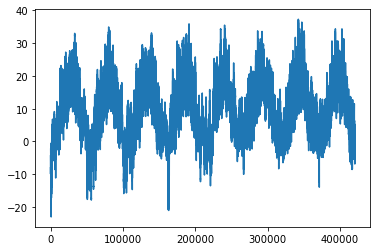

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

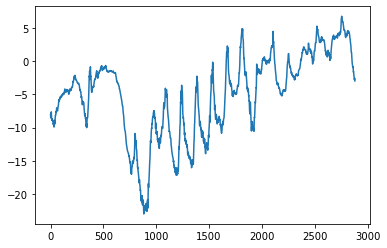

In [4]:
plt.plot(range(2880), temperature[:2880])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

In [12]:


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 11ms/step - loss: 12.1366 - mae: 2.6911 - val_loss: 10.7971 - val_mae: 2.5814
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 8.8767 - mae: 2.3475 - val_loss: 10.6472 - val_mae: 2.5760
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.1876 - mae: 2.2530 - val_loss: 10.5474 - val_mae: 2.5667
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 7.7799 - mae: 2.1965 - val_loss: 11.4870 - val_mae: 2.6893
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.4733 - mae: 2.1546 - val_loss: 11.4065 - val_mae: 2.6820
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 7.2405 - mae: 2.1219 - val_loss: 10.6546 - val_mae: 2.5929
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.0727 - mae: 2.0963 - val_loss: 10.8654 - val_mae: 2.6165
Epoch 8/10
819/819 [==============================] - 9s 11

**Plotting results**

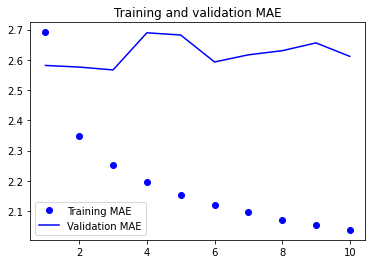

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

* A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.
* You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).


In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 31ms/step - loss: 22.5850 - mae: 3.7067 - val_loss: 19.8028 - val_mae: 3.5525
Epoch 2/10
819/819 [==============================] - 25s 31ms/step - loss: 15.4818 - mae: 3.1136 - val_loss: 15.1616 - val_mae: 3.0532
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 14.2543 - mae: 2.9892 - val_loss: 15.0375 - val_mae: 3.0299
Epoch 4/10
819/819 [==============================] - 25s 31ms/step - loss: 13.5078 - mae: 2.9137 - val_loss: 15.0410 - val_mae: 3.0501
Epoch 5/10
819/819 [==============================] - 26s 32ms/step - loss: 12.9018 - mae: 2.8484 - val_loss: 14.4381 - val_mae: 2.9771
Epoch 6/10
819/819 [==============================] - 25s 31ms/step - loss: 12.3375 - mae: 2.7833 - val_loss: 15.4761 - val_mae: 3.0945
Epoch 7/10
819/819 [==============================] - 25s 30ms/step - loss: 11.9001 - mae: 2.7358 - val_loss: 15.0738 - val_mae: 3.0481
Epoch 8/10
819/819 [============================

#### Reasons why Conv1D model is not a good choice for weather sequence data:
1. Weather data is not translation invariant
2. Order of data matters. We are literally destroying that by using maxPooling and global average pooling. recent past has higher impact on tomorrow weather than data from 7 days ago.

### A first recurrent baseline

**A simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 64ms/step - loss: 39.0368 - mae: 4.5485 - val_loss: 12.0472 - val_mae: 2.6398
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 10.8608 - mae: 2.5664 - val_loss: 9.9120 - val_mae: 2.4479
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 9.8192 - mae: 2.4413 - val_loss: 9.6878 - val_mae: 2.4217
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 9.3150 - mae: 2.3733 - val_loss: 9.7006 - val_mae: 2.4290
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 8.9122 - mae: 2.3237 - val_loss: 9.5903 - val_mae: 2.4136
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 8.6142 - mae: 2.2845 - val_loss: 9.5708 - val_mae: 2.4169
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 8.3606 - mae: 2.2531 - val_loss: 9.5819 - val_mae: 2.4227
Epoch 8/10
819/819 [==============================] - 48s 5

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [16]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 117s 141ms/step - loss: 29.0440 - mae: 3.9673 - val_loss: 10.0154 - val_mae: 2.4759
Epoch 2/50
819/819 [==============================] - 116s 141ms/step - loss: 15.0591 - mae: 3.0174 - val_loss: 9.4226 - val_mae: 2.3955
Epoch 3/50
819/819 [==============================] - 116s 142ms/step - loss: 14.2910 - mae: 2.9335 - val_loss: 9.4385 - val_mae: 2.3908
Epoch 4/50
819/819 [==============================] - 106s 130ms/step - loss: 13.6255 - mae: 2.8653 - val_loss: 9.0602 - val_mae: 2.3484
Epoch 5/50
819/819 [==============================] - 114s 139ms/step - loss: 13.1612 - mae: 2.8162 - val_loss: 9.5999 - val_mae: 2.4092
Epoch 6/50
819/819 [==============================] - 115s 140ms/step - loss: 12.7902 - mae: 2.7749 - val_loss: 9.2396 - val_mae: 2.3615
Epoch 7/50
819/819 [==============================] - 117s 143ms/step - loss: 12.4374 - mae: 2.7377 - val_loss: 9.1998 - val_mae: 2.3517
Epoch 8/50
819/819 [====================

In [22]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 267s 322ms/step - loss: 25.5684 - mae: 3.7265 - val_loss: 9.4556 - val_mae: 2.3735
Epoch 2/50
819/819 [==============================] - 273s 333ms/step - loss: 14.0243 - mae: 2.9045 - val_loss: 8.8961 - val_mae: 2.3035
Epoch 3/50
819/819 [==============================] - 274s 335ms/step - loss: 13.2463 - mae: 2.8216 - val_loss: 9.1344 - val_mae: 2.3449
Epoch 4/50
819/819 [==============================] - 275s 335ms/step - loss: 12.6466 - mae: 2.7589 - val_loss: 8.6718 - val_mae: 2.2749
Epoch 5/50
819/819 [==============================] - 277s 338ms/step - loss: 12.2366 - mae: 2.7144 - val_loss: 8.7690 - val_mae: 2.2927
Epoch 6/50
819/819 [==============================] - 283s 345ms/step - loss: 11.7819 - mae: 2.6617 - val_loss: 9.1887 - val_mae: 2.3557
Epoch 7/50
819/819 [==============================] - 6206s 8s/step - loss: 11.4134 - mae: 2.6251 - val_loss: 9.4306 - val_mae: 2.3878
Epoch 8/50
819/819 [=======================

KeyboardInterrupt: 

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

In [ ]:
# yield samples[:, ::-1, :]

In [ ]:
#       abcde
#    /        \
#   /          \
# abcde       edcba (reverse)
#   |           |
#  RNN         RNN
#   \           /
#    \         /
#      Merge(add, concatenate)
#        |
#        |

Tasks:
 - Adjust no. of units in RNN/ LSTM layer
 - Tweak optimizer or try other
 - Try stack of dense instead of single dense post RNN model
 - Improve the input of the mode:
     - Longer/shorter sequence
     - Different sampling rate
     - Feature engineering